In [1]:
from src.training.model import TransformerClassifier
from src.utils import load_config

import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

In [3]:
input_dataset = f"../../output_data/{env}/supervised_dataset.parquet"
input_outliers = (
    f"../../output_reports/{env}/outlier_detection/detected_outliers.parquet"
)

In [4]:
known_classes = pd.read_parquet(input_dataset)
outliers_found = pd.read_parquet(input_outliers)

In [5]:
features = training_config.training[model_type].features
target = training_config.training[model_type].target

In [6]:
known_classes = known_classes[[features, target]]
outliers_found = outliers_found[[features, target]]

In [7]:
num_labels = known_classes[target].nunique()

In [8]:
clf = TransformerClassifier(
    model_name=None,
    num_labels=num_labels,
    local_model_path="../../output_models/prod/trained_model",
)

# Get embeddings for known classes and outliers

In [9]:
# Generate embeddings for all rows
embeddings = clf.get_embeddings(known_classes[features].values)
known_classes["embeddings"] = [e for e in embeddings]

In [10]:
# Generate embeddings for all rows
embeddings = clf.get_embeddings(outliers_found[features].values)
outliers_found["embeddings"] = [e for e in embeddings]

# Find centroids for known classes and outliers

In [11]:
def find_centroids(df, target_column):
    """Find the centroid of the embeddings for each class in the target_column"""
    return df.groupby(target_column)["embeddings"].apply(
        lambda group: np.mean(np.vstack(group), axis=0)
    )

In [12]:
centroids = find_centroids(known_classes, target)

# Find mean distance of each row to the centroids of known classes

In [13]:
from sklearn.metrics.pairwise import cosine_distances


def find_distance_to_centroids(
    df, centroids, target_column="label", embedding_column="embeddings"
):
    """
    Find the cosine distance of each row's embedding to the centroid of its class.

    Parameters:
        df (pd.DataFrame): The DataFrame containing embeddings and target classes.
        centroids (pd.Series): A series where the index is the class and the value is the centroid embedding.
        target_column (str): The column name in df representing the target classes.
        embedding_column (str): The column name in df representing the embeddings.

    Returns:
        pd.Series: A series containing the cosine distance for each row in the DataFrame.
    """
    # Convert centroids to a dictionary for efficient lookup
    centroids_dict = centroids.to_dict()

    def compute_distance(row):
        # Retrieve the centroid for the row's class
        centroid = centroids_dict[row[target_column]]
        # Compute cosine similarity
        distance = cosine_distances([row[embedding_column]], [centroid])[0][0]
        return distance

    # Apply the distance computation for each row
    return df.apply(compute_distance, axis=1)

In [14]:
known_classes["distance_to_centroids"] = find_distance_to_centroids(
    known_classes, centroids
)

In [15]:
# Calculate mean distance from centroids of each known classes
mean_distance = known_classes.groupby(target)["distance_to_centroids"].mean()

In [16]:
known_classes_info = centroids.to_frame("centroid").join(
    mean_distance.to_frame("mean_distance")
)

In [17]:
known_classes_info

,centroid,mean_distance
label,,
0,"[0.64499325, -0.7603027, -0.45246407, 0.201125...",0.083344
1,"[0.87599444, -0.9251018, 0.071074955, -0.77208...",0.120259


# Clustering of outliers

In [18]:
def perform_dbscan_grid_search(embeddings, param_grid):
    """
    Perform grid search to find the best DBSCAN parameters using silhouette score.

    Parameters:
        embeddings (np.ndarray): Array of text embeddings to cluster.
        param_grid (dict): Dictionary of parameters for DBSCAN.

    Returns:
        dict: Best parameters and the corresponding silhouette score.
        DBSCAN: Fitted DBSCAN model with best parameters.
    """
    best_score = -1  # Silhouette score ranges from -1 to 1
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        # Train DBSCAN model with the current set of parameters
        model = DBSCAN(**params)
        labels = model.fit_predict(embeddings)

        # Log intermediate results
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Only calculate silhouette score if there are at least 2 clusters
        if num_clusters > 1:
            score = silhouette_score(embeddings, labels)
            if score > best_score:
                best_score = score
                best_params = params
                best_model = model

    if best_model is None:
        print("No valid clustering found. Adjust parameters or check the data.")
    return {"best_params": best_params, "best_score": best_score}, best_model

In [19]:
# Example dataset: Replace this with your text embeddings
embeddings = np.vstack(outliers_found["embeddings"])

# Define a parameter grid for DBSCAN
param_grid = {
    "eps": np.arange(0.1, 20, 0.1),
    "min_samples": range(2, 20, 1),
    "metric": ["cosine", "euclidean"],
}

# Perform grid search
results, best_model = perform_dbscan_grid_search(embeddings, param_grid)

# Display results
print("Best Parameters:", results["best_params"])
print("Best Silhouette Score:", results["best_score"])

# Retrieve cluster labels from the best model
cluster_labels = best_model.labels_
print("Cluster Labels:", cluster_labels)

Best Parameters: {'eps': 15.6, 'metric': 'euclidean', 'min_samples': 13}
Best Silhouette Score: 0.24065837
Cluster Labels: [ 0  0  1  0 -1  0  1  1  0  1 -1  0  0  0  0 -1 -1  0  0  0  0  0  0 -1
  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0 -1  0  0
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
  0  0  1  0  0  0 -1 -1  1  0  0  0  0  0  0  0  0  0]


In [20]:
outliers_found["cluster"] = cluster_labels

In [21]:
outliers_centroids = find_centroids(outliers_found, "cluster")

In [22]:
outliers_found["distance_to_centroids"] = find_distance_to_centroids(
    outliers_found, outliers_centroids, target_column="cluster"
)

In [23]:
outliers_info = outliers_centroids.to_frame("centroid").join(
    outliers_found.groupby("cluster")["distance_to_centroids"]
    .mean()
    .to_frame("mean_distance")
)

In [24]:
outliers_info

,centroid,mean_distance
cluster,,
-1,"[0.95425683, -0.82077795, -0.0175265, -0.61728...",0.165599
0,"[0.7502181, -0.6801476, -0.2928251, 0.01186235...",0.144231
1,"[0.8247813, -0.833732, 0.051665276, -1.0820456...",0.136255


In [25]:
known_classes_info

,centroid,mean_distance
label,,
0,"[0.64499325, -0.7603027, -0.45246407, 0.201125...",0.083344
1,"[0.87599444, -0.9251018, 0.071074955, -0.77208...",0.120259


# Calculate distance of outliers to known classes centroids

In [26]:
def cluster_and_find_new_class(
    df_outliers: pd.DataFrame, known_class_info: pd.DataFrame
):
    """
    Cluster the outliers and find new classes based on the distance to known class centroids.

    :param df_outliers: DataFrame containing outlier embeddings and their cluster labels.
                        Must contain a column 'embeddings' with embeddings as numpy arrays.
    :param known_class_info: DataFrame containing known class centroids.
                             Must contain columns 'centroid' with centroids as numpy arrays.
    :return: Updated DataFrame with new columns 'new_class' and 'special_case'.
    """

    # Extract embeddings from the outlier DataFrame
    emb_outliers = np.stack(df_outliers["embeddings"].values, axis=0)

    # Initialize new columns
    df_outliers["new_class"] = False  # default
    df_outliers["special_case"] = False  # default

    # Known class centroids as a numpy array
    known_centroids = np.stack(
        known_class_info["centroid"].values, axis=0
    )  # shape (num_classes, embedding_dim)

    # Iterate over unique clusters in the outliers DataFrame
    unique_clusters = df_outliers["cluster"].unique()
    for cl_id in unique_clusters:
        if cl_id == -1:
            # DBSCAN assigns -1 to noise
            df_outliers.loc[df_outliers["cluster"] == -1, "special_case"] = True
            continue

        # Extract embeddings for the current cluster
        mask = df_outliers["cluster"] == cl_id
        cluster_emb = emb_outliers[mask]

        # Compute the centroid of the cluster
        centroid = cluster_emb.mean(axis=0, keepdims=True)  # shape (1, embedding_dim)

        # Compute cosine distances to known class centroids
        distances = cosine_distances(centroid, known_centroids)[
            0
        ]  # shape (num_classes,)

        # Find the minimum distance
        min_distance = np.min(distances)
        min_distance_class = known_class_info.index[np.argmin(distances)]
        distance_threshold = known_class_info.loc[min_distance_class, "mean_distance"]

        print(
            f"Cluster {cl_id}: Min distance = {min_distance:.4f} to class {min_distance_class} and threshold = {distance_threshold:.4f}"
        )

        # If the minimum distance exceeds the threshold, label the cluster as a new class
        if min_distance > distance_threshold:
            df_outliers.loc[mask, "new_class"] = True
            print(f"Cluster {cl_id} is a new class")
        else:
            print(f"Cluster {cl_id} is an existing class")

    return df_outliers

In [31]:
new_class = cluster_and_find_new_class(outliers_found, known_classes_info)

Cluster 0: Min distance = 0.2214 to class 0 and threshold = 0.0833
Cluster 0 is a new class
Cluster 1: Min distance = 0.1004 to class 1 and threshold = 0.1203
Cluster 1 is an existing class


In [32]:
new_class.groupby(["cluster", "label"]).size()

cluster  label
-1       0         1
         1         4
         2         3
 0       0        12
         1         5
         2        55
 1       1         4
         2         6
dtype: int64

In [33]:
new_class.groupby(["label", "new_class"]).size()

label  new_class
0      False         1
       True         12
1      False         8
       True          5
2      False         9
       True         55
dtype: int64

In [34]:
new_class[new_class["new_class"] == True]

,processed_text_to_analyse,label,embeddings,cluster,distance_to_centroids,new_class,special_case
0,pantalla congelada lengua emparejar bateria ca...,0,"[1.1179554, -0.7045866, -0.112711154, -0.06192...",0,0.146103,True,False
1,pensar pantalla quita blueface pantalla bloque...,1,"[1.2228342, -0.9498797, -0.33459154, -0.356697...",0,0.096628,True,False
3,pantallas bloqueadas tacto responde pantalla p...,0,"[1.3592331, -0.79204917, -0.3811632, -0.202186...",0,0.155741,True,False
5,termostato funciona pantalla digital completam...,0,"[1.1948981, -1.3508228, -0.07576577, -0.814956...",0,0.392237,True,False
8,1 2 blueface funciona funciona normalmente pan...,1,"[0.9113356, -1.0912932, -0.43760234, 0.0765032...",0,0.221131,True,False
...,...,...,...,...,...,...,...
85,visto linea directa comunicacion caja registra...,2,"[1.073865, -0.55823165, -0.92930335, 0.4183844...",0,0.158515,True,False
86,numero archivo linea directa 240300921 sustitu...,2,"[0.71984005, -0.7580546, -0.2647118, 0.4971769...",0,0.101424,True,False
87,numero archivo linea directa 240300921 sustitu...,2,"[0.9775894, -0.89244354, -0.17828754, 0.163492...",0,0.101483,True,False
88,2 mandos distancia defectuosos comunicaciones ...,2,"[1.2192621, -0.9650607, -0.021704776, 0.369362...",0,0.165564,True,False


In [58]:
print(
    f"Total new classes found:  {len(new_class[new_class["new_class"]]["cluster"].unique())}"
)

Total new classes found:  1


In [103]:
from src.clustering.utils import ensure_output_folder

ensure_output_folder(f"../../output_reports/{env}/clustering")
new_class.to_parquet(f"../../output_reports/{env}/clustering/temp_new_class.parquet")

In [68]:
import importlib
from src.clustering import utils  # Import the module

importlib.reload(utils)  # Reload the module

# Now you can access the updated function
from src.clustering.utils import save_all_reports_and_plots

paths = save_all_reports_and_plots(
    embeddings=embeddings,
    labels=cluster_labels,
    centroids=outliers_centroids,
    outliers=outliers_found,
    outliers_info=outliers_info,
    output_folder=f"../../output_reports/{env}/",
)

In [59]:
outliers_centroids

cluster
-1    [0.95425683, -0.82077795, -0.0175265, -0.61728...
 0    [0.7502181, -0.6801476, -0.2928251, 0.01186235...
 1    [0.8247813, -0.833732, 0.051665276, -1.0820456...
Name: embeddings, dtype: object

# Metrics

In [83]:
cluster_df = (
    new_class.groupby(["cluster", "label"]).size().to_frame("count").reset_index()
)
new_class_df = (
    new_class.groupby(["label", "new_class"]).size().to_frame("count").reset_index()
)

In [86]:
cluster_df

,cluster,label,count
0,-1,0,1
1,-1,1,4
2,-1,2,3
3,0,0,12
4,0,1,5
5,0,2,55
6,1,1,4
7,1,2,6


In [84]:
new_class_df

,label,new_class,count
0,0,False,1
1,0,True,12
2,1,False,8
3,1,True,5
4,2,False,9
5,2,True,55


In [100]:
from matplotlib import pyplot as plt

# Calculate TP, FP, FN
TP = new_class_df[(new_class_df["new_class"] == True) & (new_class_df["label"] == 2)][
    "count"
].sum()
FP = new_class_df[(new_class_df["new_class"] == True) & (new_class_df["label"] != 2)][
    "count"
].sum()
FN = new_class_df[(new_class_df["new_class"] == False) & (new_class_df["label"] == 2)][
    "count"
].sum()

# Contamination Rate (Noise in new class)
noise_as_new_class = cluster_df[
    (cluster_df["cluster"] == -1) & (cluster_df["label"] == 2)
]["count"].sum()
total_new_class = new_class_df[new_class_df["new_class"] == True]["count"].sum()
contamination_rate = noise_as_new_class / total_new_class if total_new_class > 0 else 0

# Precision, Recall, F1-Score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = (
    2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
)

# Print values
print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"Total New Class: {total_new_class}")
print(f"Noise as New Class: {noise_as_new_class}")


# Print Metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")
print(f"Contamination Rate: {contamination_rate:.2f}")

TP: 55
FP: 17
FN: 9
Total New Class: 72
Noise as New Class: 3
Precision: 0.76
Recall: 0.86
F1-Score: 0.81
Contamination Rate: 0.04


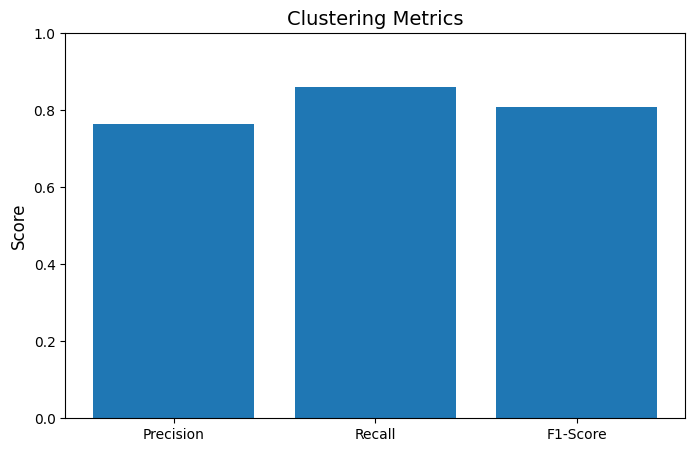

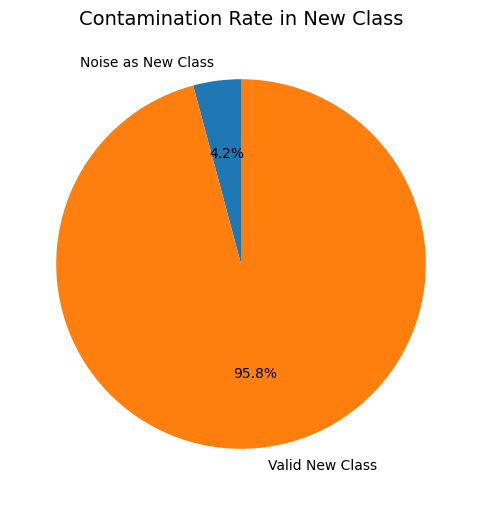

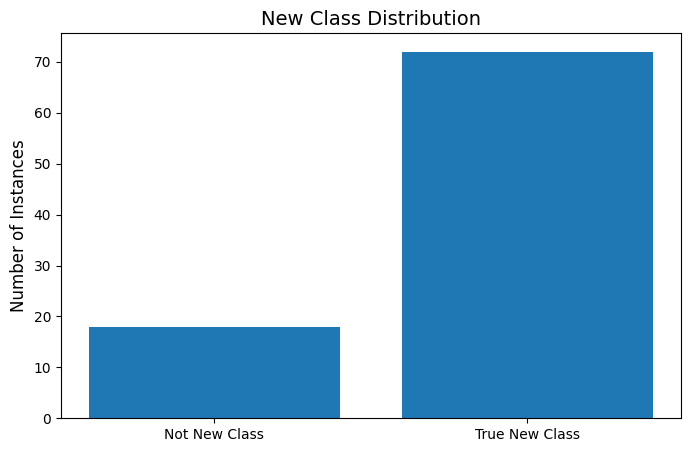

In [102]:
# Visualization
# 1. Precision, Recall, F1-Score Bar Chart
plt.figure(figsize=(8, 5))
metrics = ["Precision", "Recall", "F1-Score"]
values = [precision, recall, f1_score]
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.title("Clustering Metrics", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.show()

# 2. Contamination Rate Pie Chart
plt.figure(figsize=(6, 6))
labels = ["Noise as New Class", "Valid New Class"]
sizes = [noise_as_new_class, total_new_class - noise_as_new_class]
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Contamination Rate in New Class", fontsize=14)
plt.show()

# 3. New Class Distribution
plt.figure(figsize=(8, 5))
new_class_labels = ["Not New Class", "True New Class"]
counts = [
    new_class_df[new_class_df["new_class"] == False]["count"].sum(),
    new_class_df[new_class_df["new_class"] == True]["count"].sum(),
]
plt.bar(new_class_labels, counts)
plt.title("New Class Distribution", fontsize=14)
plt.ylabel("Number of Instances", fontsize=12)
plt.show()